In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_DIR = "drive/MyDrive/AI_X/"

### 실험

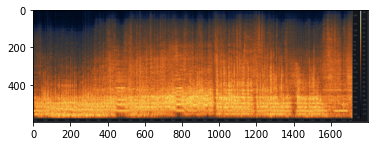

In [ ]:
from PIL import Image
import matplotlib.pylab as plt

 
image1 = Image.open('drive/MyDrive/imim.jpg')
plt.imshow(image1)

In [ ]:
#이미지의 크기 출력
print(image1.size)

(1800, 600)


In [ ]:
# 이미지 자르기 crop함수 이용 ex. crop(가로시작점, 세로시작점, 가로범위, 세로범위)
croppedImage=image1.crop((0,0,1715,580))
 

In [ ]:
croppedImage.size

(1700, 580)

In [ ]:
croppedImage.show()

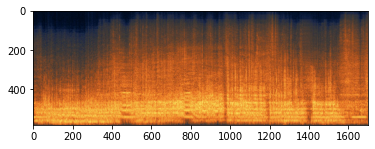

In [ ]:
plt.imshow(croppedImage)

### 2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils.vis_utils import plot_model

from pathlib import Path
import pickle, PIL, io, os
import zipfile
from os.path import exists
from tqdm import tqdm

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2022-11-22 14:36:49--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-11-22 14:36:49 (112 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
dataset = DATA_DIR+'Spectrogram_data'
walk_throgh_dir(dataset);u

There are 21 directories and 0 images in 'drive/MyDrive/AI_X/Spectrogram_data'.
There are 0 directories and 1059 images in 'drive/MyDrive/AI_X/Spectrogram_data/강아지짓는소리'.
There are 0 directories and 1120 images in 'drive/MyDrive/AI_X/Spectrogram_data/망치질소리'.
There are 0 directories and 1046 images in 'drive/MyDrive/AI_X/Spectrogram_data/골프연습장의타구음'.
There are 0 directories and 1000 images in 'drive/MyDrive/AI_X/Spectrogram_data/등하원아이들떠드는소리'.
There are 0 directories and 1041 images in 'drive/MyDrive/AI_X/Spectrogram_data/가구끄는소리'.
There are 0 directories and 1044 images in 'drive/MyDrive/AI_X/Spectrogram_data/드럼세탁기소리'.
There are 0 directories and 1063 images in 'drive/MyDrive/AI_X/Spectrogram_data/골프퍼팅(골굴리는소리)'.
There are 0 directories and 1065 images in 'drive/MyDrive/AI_X/Spectrogram_data/런닝머신에서뛰는소리'.
There are 0 directories and 1078 images in 'drive/MyDrive/AI_X/Spectrogram_data/문여닫는소리'.


In [ ]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
image_df

,Filepath,Label
0,drive/MyDrive/AI_X/Spectrogram_data/강아지짓...,강아지짓는소리
1,drive/MyDrive/AI_X/Spectrogram_data/강아지짓...,강아지짓는소리
2,drive/MyDrive/AI_X/Spectrogram_data/강아지짓...,강아지짓는소리
3,drive/MyDrive/AI_X/Spectrogram_data/강아지짓...,강아지짓는소리
4,drive/MyDrive/AI_X/Spectrogram_data/강아지짓...,강아지짓는소리
...,...,...
22260,drive/MyDrive/AI_X/Spectrogram_data/화장실무...,화장실물내리는소리
22261,drive/MyDrive/AI_X/Spectrogram_data/화장실무...,화장실물내리는소리
22262,drive/MyDrive/AI_X/Spectrogram_data/화장실무...,화장실물내리는소리
22263,drive/MyDrive/AI_X/Spectrogram_data/화장실무...,화장실물내리는소리


In [ ]:
le = preprocessing.LabelEncoder()
le.fit(image_df.Label)
le.classes_

array(['가구끄는소리', '강아지짓는소리', '골프연습장의타구음',
       '골프퍼팅(골굴리는소리)', '드럼세탁기소리',
       '등하원아이들떠드는소리', '런닝머신에서뛰는소리',
       '망치질소리', '문여닫는소리', '바이올린연주소리',
       '샤워할때물소리', '식기세척기소리',
       '심야에이륜차가빠르게주행하는소리',
       '심야에자동차가빠르게주행하는소리', '아이들발걸음소리',
       '어른발걸음소리', '에어컨실외기의가동소리',
       '진공청소기소리', '통돌이세탁기소리', '피아노연주소리',
       '화장실물내리는소리'], dtype=object)

In [ ]:
train_labels = np.array(le.transform(image_df.Label))
train_labels

array([ 1,  1,  1, ..., 20, 20, 20])

In [ ]:
le.inverse_transform(train_labels)

array(['강아지짓는소리', '강아지짓는소리', '강아지짓는소리', ...,
       '화장실물내리는소리', '화장실물내리는소리',
       '화장실물내리는소리'], dtype=object)

In [ ]:
IMAGE_SIZE = (150, 50)

In [ ]:
def load_images(files):
    images = None
    for _, im in tqdm(enumerate(files)):
        image = PIL.Image.open(im).crop((0,0,1715,580)).convert('L').resize(IMAGE_SIZE)
        image = np.expand_dims(np.array(image, dtype=int), axis=0)
        images = image if images is None else np.append(images, image, axis=0)
    return images

In [ ]:
TRAIN_IMAGES_FILE = os.path.join(DATA_DIR + "train_images.pkl")

if exists(TRAIN_IMAGES_FILE):
    with open(TRAIN_IMAGES_FILE, 'rb') as f:
        train_images = pickle.load(f)
else:
    train_images = load_images(image_df.Filepath)
    with open(TRAIN_IMAGES_FILE, 'wb') as f:
        pickle.dump(train_images, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
train_images.shape

(22265, 50, 150)

In [ ]:
x = train_images
y = train_labels

X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3, shuffle=True, stratify=train_labels)

In [ ]:
X_train = np.array(X_train) / 255
X_valid = np.array(X_valid) / 255

In [ ]:
y_train = np.array(y_train)
y_valid = np.array(y_valid)

### 보류

In [ ]:
datagen = ImageDataGenerator(
    featurewise_center=False,              # 데이터셋에 대해 입력 평균을 0으로 설정
    samplewise_center=False,               # 각 샘플 평균을 0으로 설정
    featurewise_std_normalization=False,   # 데이터 세트의 표준으로 입력 나눕니다.
    samplewise_std_normalization=False,    # 각 입력을 std로 나눕니다.
    width_shift_range=0.15                 # 이미지를 가로로 무작위로 이동(전체 너비의 일부)
)

In [ ]:
datagen.fit(X_train)

### 다시

In [ ]:
!pip install autokeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 162 kB 4.1 MB/s 
     |████████████████████████████████| 135 kB 40.8 MB/s 
     |████████████████████████████████| 1.6 MB 51.3 MB/s 


In [ ]:
import autokeras as ak

In [ ]:
# Initialize the image classifier.
clf = ak.ImageClassifier(overwrite=True, max_trials=3)
# Feed the image classifier with training data.
clf.fit(X_train, y_train, epochs=10)

Trial 3 Complete [02h 14m 17s]
val_loss: 0.1866484433412552

Best val_loss So Far: 0.1866484433412552
Total elapsed time: 02h 45m 29s


Epoch 1/10


Not enough memory, reduce batch size to 16.
Epoch 1/10
975/975 [==============================] - 941s 965ms/step - loss: 1.2021 - accuracy: 0.6665
Epoch 2/10
975/975 [==============================] - 940s 964ms/step - loss: 0.4318 - accuracy: 0.8578
Epoch 3/10
975/975 [==============================] - 940s 964ms/step - loss: 0.2903 - accuracy: 0.9037
Epoch 4/10
975/975 [==============================] - 941s 965ms/step - loss: 0.2147 - accuracy: 0.9283
Epoch 5/10
975/975 [==============================] - 936s 960ms/step - loss: 0.1582 - accuracy: 0.9471
Epoch 6/10
975/975 [==============================] - 936s 960ms/step - loss: 0.1179 - accuracy: 0.9602
Epoch 7/10
975/975 [==============================] - 940s 964ms/step - loss: 0.0952 - accuracy: 0.9675
Epoch 8/10
975/975 [==============================] - 940s 964ms/step - loss: 0.0688 - accuracy: 0.9756
Epoch 9/10
975/975 [==============================] - 938s 962ms/step - loss: 0.0614 - accuracy: 0.9794
Epoch 10/10
975/975 

In [ ]:

# Evaluate the best model with testing data.
print(clf.evaluate(X_valid, y_valid))

209/209 [==============================] - 71s 339ms/step
[['16']
 ['8']
 ['6']
 ...
 ['2']
 ['12']
 ['16']]


209/209 [==============================] - 80s 355ms/step - loss: 0.4510 - accuracy: 0.8600
[0.4510452449321747, 0.860029935836792]


In [ ]:
predicted_X = clf.predict(X_valid)
print(predicted_X)

In [ ]:
y_valid

array([16,  8,  6, ...,  2, 12, 13])

In [ ]:
predicted_y = np.array(predicted_X, dtype=int)

In [ ]:
predicted_X

array([[16],
       [ 8],
       [ 6],
       ...,
       [ 2],
       [12],
       [16]])

In [ ]:
print(classification_report(le.inverse_transform(y_valid), le.inverse_transform(predicted_X)))

                                      precision    recall  f1-score   support

                       가구끄는소리       0.99      0.59      0.74       312
                   강아지짓는소리       0.96      0.97      0.97       318
             골프연습장의타구음       0.98      0.94      0.96       314
         골프퍼팅(골굴리는소리)       0.99      0.87      0.93       319
                    드럼세탁기소리       0.81      0.70      0.75       313
          등하원아이들떠드는소리       1.00      0.95      0.97       300
            런닝머신에서뛰는소리       0.88      0.97      0.92       320
                        망치질소리       0.65      0.99      0.78       336
                     문여닫는소리       0.89      0.95      0.92       323
                 바이올린연주소리       1.00      0.98      0.99       337
                    샤워할때물소리       0.93      0.97      0.95       316
                    식기세척기소리       0.92      0.43      

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
model = clf.export_model()

In [ ]:
model.save(DATA_DIR+"model_autokeras.h5")

In [ ]:
from tensorflow.keras.models import load_model

loaded_model = load_model(DATA_DIR+"model_autokeras.h5", custom_objects = ak.CUSTOM_OBJECTS)

In [ ]:
loaded_model

In [ ]:
predicted_y = loaded_model.predict(X_valid)
print(predicted_y)

209/209 [==============================] - 81s 330ms/step
[[7.70675659e-04 6.63183688e-04 1.17969164e-03 ... 3.23217316e-03
  3.59632983e-03 1.42202550e-03]
 [9.33568954e-05 4.94915294e-05 1.16320516e-05 ... 7.12432666e-04
  1.17327283e-04 2.92093591e-05]
 [1.19706790e-04 2.65673065e-04 7.82410440e-04 ... 8.71779572e-04
  1.46157970e-03 6.32860116e-04]
 ...
 [1.70024997e-03 1.04842335e-01 6.79317296e-01 ... 2.35592341e-03
  4.85598436e-03 9.34137439e-04]
 [3.75598232e-04 1.88951194e-03 8.14981409e-04 ... 3.62409651e-02
  2.06357497e-03 7.02942070e-03]
 [1.48660946e-03 1.61978032e-03 4.20125062e-03 ... 7.66279828e-03
  9.00790468e-03 1.10444659e-03]]


In [ ]:
predicted_y = le.inverse_transform(np.array([np.argmax(pred) for pred in loaded_model.predict(X_valid)]))

209/209 [==============================] - 69s 332ms/step


In [ ]:
print(predicted_y)

['에어컨실외기의가동소리' '문여닫는소리' '런닝머신에서뛰는소리'
 ... '골프연습장의타구음' '심야에이륜차가빠르게주행하는소리'
 '에어컨실외기의가동소리']


In [ ]:
print(classification_report(le.inverse_transform(y_valid), predicted_y))

                                      precision    recall  f1-score   support

                       가구끄는소리       0.99      0.59      0.74       312
                   강아지짓는소리       0.96      0.97      0.97       318
             골프연습장의타구음       0.98      0.94      0.96       314
         골프퍼팅(골굴리는소리)       0.99      0.87      0.93       319
                    드럼세탁기소리       0.81      0.70      0.75       313
          등하원아이들떠드는소리       1.00      0.95      0.97       300
            런닝머신에서뛰는소리       0.88      0.97      0.92       320
                        망치질소리       0.65      0.99      0.78       336
                     문여닫는소리       0.89      0.95      0.92       323
                 바이올린연주소리       1.00      0.98      0.99       337
                    샤워할때물소리       0.93      0.97      0.95       316
                    식기세척기소리       0.92      0.43      